In [2]:
import tensorflow as tf
import numpy
import pandas as pd 
from tensorflow.keras import layers 
from tensorflow.keras.utils import to_categorical

from numpy import random

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import cPickle as pickle


# data = pd.read_csv('raw.txt', sep='\t')
# types = pd.read_csv('types-numeric.txt', sep='\t')
# labels = pd.read_csv('types-labels.txt', sep='\t')


In [45]:
# Top 10 most important features, ranked by random forest 

#for f in range(train.shape[1]):
for f in range(0,10):
    print("%d. feature %s (%f)" % (f + 1 , data.columns[indices[f]], importances[indices[f]]))


1. feature hsa_miR_205_5p (0.011021)
2. feature hsa_miR_135a_5p (0.010891)
3. feature hsa_miR_194_5p (0.010295)
4. feature hsa_miR_192_5p (0.010200)
5. feature hsa_miR_375 (0.009484)
6. feature hsa_miR_205_3p (0.009425)
7. feature hsa_miR_944 (0.008933)
8. feature hsa_miR_200c_5p (0.008926)
9. feature hsa_miR_122_5p (0.008564)
10. feature hsa_miR_194_3p (0.008348)


In [3]:
#### CAREFUL
#### You are about to load in new variables from the cluster 
#### To use for further visualization 
filename='200e-2e5e-dnam'
with open(filename, 'rb') as fp:
    learnloss = pickle.load(fp)
    histories = pickle.load(fp)

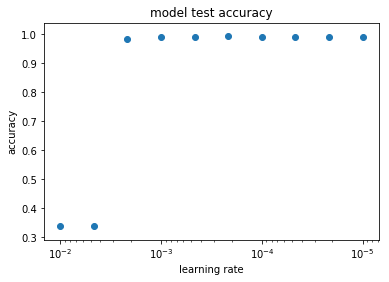

In [5]:
## First plot accuracy vs learning rate to decide on a good range 

def visualizeLearnLossRange(learnloss): 
    plt.title('model test accuracy')
    plt.xscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('learning rate')
    plt.scatter(list(learnloss.keys()),list(learnloss.values()))
    plt.gca().invert_xaxis()
    #plt.savefig("accuracy_learningrate_range.pdf")
    plt.show()

visualizeLearnLossRange(learnloss)


In [7]:
## Look at rates and decide lower/upper bound 
max_acc = max(learnloss.values())  # maximum value
max_lr = [k for k, v in learnloss.items() if v == max_acc] # getting all keys containing the `maximum`
print("Max test accuracy: ")
print(max_acc, max_lr)

# print(ll)
# print("Mean Accuracy: " + str(numpy.mean(histories[ll]['acc'])))
# print("Max Accuracy: " + str(max(histories[ll]['acc'])))
orderedkeys = []
for ll in learnloss:
    orderedkeys.append(ll)
orderedkeys = sorted(orderedkeys)

# get numbers for plotting
# good rates are above 0.77 when training 
counter = 0
goodrates = []
for ll in orderedkeys: 
#    if ll < 3e-04 and ll > 2.5e-05: 
    if learnloss[ll] > 0.77: 
        counter+=1
        goodrates.append(ll)
        print("Rate: " + str(ll) + "\tAccuracy: "+ str(learnloss[ll]))
print(counter)


filename='goodrates'
with open(filename, 'wb') as fp:
    pickle.dump(goodrates, fp)


Max test accuracy: 
(0.9932432432432432, [0.00021544346900318845])
Rate: 1e-05	Accuracy: 0.9915540540540541
Rate: 2.1544346900318867e-05	Accuracy: 0.9915540540540541
Rate: 4.641588833612782e-05	Accuracy: 0.9915540540540541
Rate: 0.0001	Accuracy: 0.9915540540540541
Rate: 0.00021544346900318845	Accuracy: 0.9932432432432432
Rate: 0.0004641588833612782	Accuracy: 0.9915540540540541
Rate: 0.001	Accuracy: 0.9898648648648649
Rate: 0.0021544346900318843	Accuracy: 0.9847972972972973
8


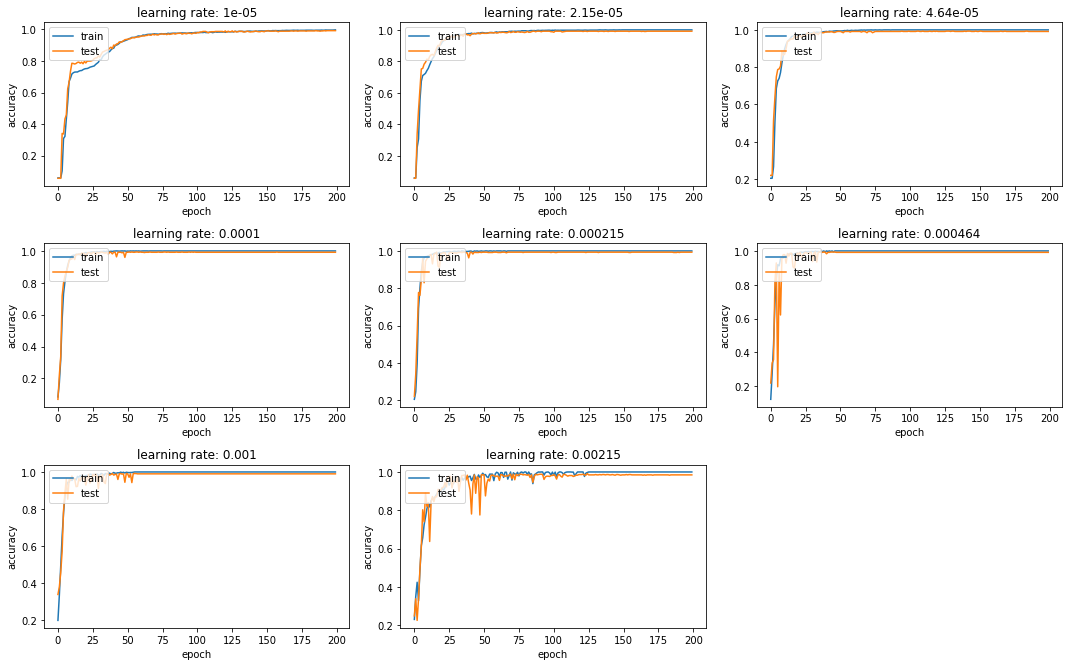

In [9]:
def visualizeEpochs(learnloss, histories):
    fig = plt.figure(figsize=(10,3))
    counter = 0
    nrRows = 4
    nrCols = 3
    for lr in goodrates: 
        # generate subplots 
        ax = fig.add_subplot(nrRows, nrCols, counter+1)
        ax.plot(histories[lr]['acc'])
        ax.plot(histories[lr]['val_acc'])
        plt.title('learning rate: ' + '{:.3g}'.format(lr))
        ax.set_ylabel('accuracy')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper left')
        counter +=1
    fig.set_figheight(12)
    fig.set_figwidth(15)
    plt.tight_layout()
    plt.savefig("accuracy_epochs.pdf")
    plt.show()
            

visualizeEpochs(learnloss, histories)

In [102]:
# Learning rate: 0.01 to 0.000001
# encoded labels are one-hot encoded 
# Test labels are treated with ravel
learnloss = {} 
histories = {}
def learnLoss(learningRate, epochs, train, encoded_train, test, encoded_test, test_labels):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(17, activation='softmax'))
    model.compile(optimizer=tf.train.RMSPropOptimizer(learningRate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(train, encoded_train, validation_data=(test, encoded_test), epochs=epochs, batch_size=32)
    
    
    # test 
    pred_y = model.predict_classes(test)
    nnyhat = confusion_matrix(test_types, pred_y)
    accuracy = metrics.accuracy_score(test_labels, pred_y)
    print("Accuracy: ", accuracy)
    learnloss[learningRate] = accuracy 
    histories[learningRate] = model.history.history

In [ ]:
learningRates =  numpy.geomspace(0.01, 0.000001, num=50)
print(learningRates)
for lr in learningRates:
    learnLoss(lr, 500, train, encoded_train, test, encoded_test, r_test_types)


In [ ]:
### CAREFUL
### You are about to DUMP and replace the current saved variables

filename='500epoch50learn'
with open(filename, 'wb')as fp:
    pickle.dump(learnloss, fp)
    pickle.dump(histories, fp)
    
filename='500epoch50learn'
with open(filename, 'rb') as fp:
    learnloss = pickle.load(fp)
    histories = pickle.load(fp)


In [81]:
filename='200epoch-10batch'
with open(filename, 'rb') as fp:
    batch_acc = pickle.load(fp)
    batch_hist = pickle.load(fp)

In [87]:
orderedkeys = []
for b in batch_acc:
    orderedkeys.append(b)
orderedkeys = sorted(orderedkeys)

counter = 0
goodrates = []
for b in orderedkeys: 
#     if learnloss[ll] > 0.77: 
#         counter+=1
#         goodrates.append(ll)
    print("Batch: " + str(b) + "\tAccuracy: "+ str(batch_acc[b]))
print(counter)

Batch: 1	Accuracy: 0.7373737373737373
Batch: 11	Accuracy: 0.7672558922558923
Batch: 21	Accuracy: 0.7243265993265994
Batch: 31	Accuracy: 0.742003367003367
Batch: 41	Accuracy: 0.7617845117845118
Batch: 51	Accuracy: 0.7441077441077442
Batch: 61	Accuracy: 0.7310606060606061
Batch: 71	Accuracy: 0.7184343434343434
Batch: 81	Accuracy: 0.7268518518518519
Batch: 91	Accuracy: 0.7264309764309764
Batch: 101	Accuracy: 0.7251683501683501
Batch: 111	Accuracy: 0.7344276094276094
Batch: 121	Accuracy: 0.7117003367003367
Batch: 131	Accuracy: 0.7293771043771043
Batch: 141	Accuracy: 0.7024410774410774
Batch: 151	Accuracy: 0.70496632996633
Batch: 161	Accuracy: 0.7175925925925926
Batch: 171	Accuracy: 0.7184343434343434
Batch: 181	Accuracy: 0.6746632996632996
Batch: 191	Accuracy: 0.6898148148148148
Batch: 201	Accuracy: 0.6712962962962963
Batch: 211	Accuracy: 0.6708754208754208
Batch: 221	Accuracy: 0.6944444444444444
Batch: 231	Accuracy: 0.6553030303030303
Batch: 241	Accuracy: 0.6632996632996633
Batch: 251	Acc

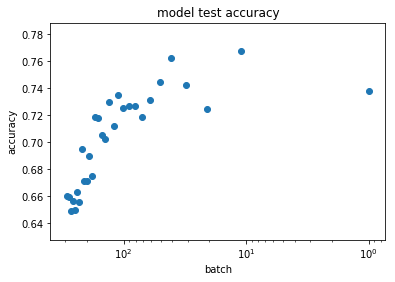

In [84]:
## First plot accuracy vs learning rate to decide on a good range 

def visualizeMetricAcc(dic): 
    plt.title('model test accuracy')
    plt.xscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('batch')
    plt.scatter(list(dic.keys()),list(dic.values()))
    plt.gca().invert_xaxis()
#     plt.axvspan(2.8e-04, 2e-05, color='yellow', alpha=0.5)
#     plt.savefig("accuracy_learningrate_range.pdf")
    plt.show()

visualizeMetricAcc(batch_acc)


In [86]:
## Look at rates and decide lower/upper bound 
max_acc = max(batch_acc.values())  # maximum value
max_lr = [k for k, v in batch_acc.items() if v == max_acc] # getting all keys containing the `maximum`
print("Max test accuracy: ")
print(max_acc, max_lr)


Max test accuracy: 
(0.7672558922558923, [11])


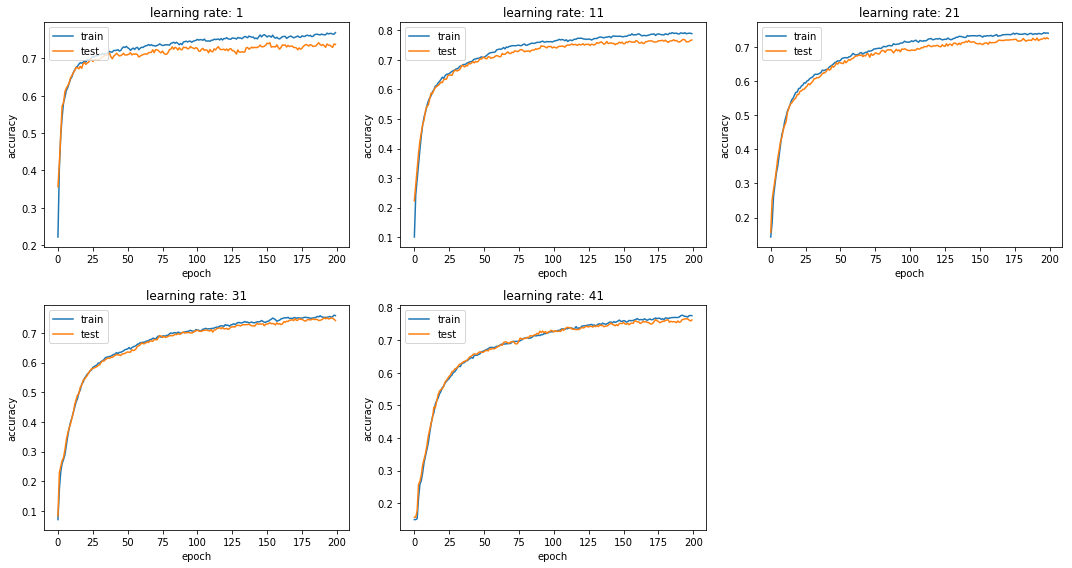

In [104]:
def visualizeEpochsGeneral(learnloss, histories):
    fig = plt.figure(figsize=(10,3))
    counter = 0
    nrRows = 2
    nrCols = 3
    for lr in learnloss: 
        if lr < 100 and lr < 50:
            ax = fig.add_subplot(nrRows, nrCols, counter+1)
            ax.plot(histories[lr]['acc'])
            ax.plot(histories[lr]['val_acc'])
            plt.title('learning rate: ' + '{:.3g}'.format(lr))
            ax.set_ylabel('accuracy')
            ax.set_xlabel('epoch')
            ax.legend(['train', 'test'], loc='upper left')
            counter +=1
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.tight_layout()
    #plt.savefig("accuracy_epochs.pdf")
    plt.show()
            

visualizeEpochsGeneral(batch_acc, batch_hist)

In [11]:
model = tf.keras.Sequential()
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(17, activation='softmax'))
model.compile(optimizer=tf.train.RMSPropOptimizer(5.1794746792312125e-05),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [48]:
model.fit(train, encoded_train, validation_data=(test, encoded_test), epochs=200, batch_size=32)

Train on 5574 samples, validate on 2376 samples
Epoch 1/200
5574/5574 [==============================] - 1s 256us/step - loss: 0.8388 - acc: 0.7384 - val_loss: 0.8616 - val_acc: 0.7315
Epoch 2/200
5574/5574 [==============================] - 1s 169us/step - loss: 0.8350 - acc: 0.7363 - val_loss: 0.8543 - val_acc: 0.7319
Epoch 3/200
5574/5574 [==============================] - 1s 172us/step - loss: 0.8317 - acc: 0.7388 - val_loss: 0.8579 - val_acc: 0.7273
Epoch 4/200
5574/5574 [==============================] - 1s 170us/step - loss: 0.8313 - acc: 0.7393 - val_loss: 0.8530 - val_acc: 0.7315
Epoch 5/200
5574/5574 [==============================] - 1s 176us/step - loss: 0.8236 - acc: 0.7417 - val_loss: 0.8508 - val_acc: 0.7306
Epoch 6/200
5574/5574 [==============================] - 1s 173us/step - loss: 0.8281 - acc: 0.7404 - val_loss: 0.8445 - val_acc: 0.7344
Epoch 7/200
5574/5574 [==============================] - 1s 171us/step - loss: 0.8233 - acc: 0.7413 - val_loss: 0.8467 - val_acc: 

5574/5574 [==============================] - 1s 170us/step - loss: 0.7722 - acc: 0.7585 - val_loss: 0.8057 - val_acc: 0.7407
Epoch 61/200
5574/5574 [==============================] - 1s 168us/step - loss: 0.7736 - acc: 0.7530 - val_loss: 0.8013 - val_acc: 0.7428
Epoch 62/200
5574/5574 [==============================] - 1s 168us/step - loss: 0.7692 - acc: 0.7544 - val_loss: 0.7986 - val_acc: 0.7441
Epoch 63/200
5574/5574 [==============================] - 1s 167us/step - loss: 0.7744 - acc: 0.7537 - val_loss: 0.8065 - val_acc: 0.7445
Epoch 64/200
5574/5574 [==============================] - 1s 167us/step - loss: 0.7759 - acc: 0.7539 - val_loss: 0.8040 - val_acc: 0.7462
Epoch 65/200
5574/5574 [==============================] - 1s 170us/step - loss: 0.7732 - acc: 0.7524 - val_loss: 0.8011 - val_acc: 0.7424
Epoch 66/200
5574/5574 [==============================] - 1s 167us/step - loss: 0.7711 - acc: 0.7558 - val_loss: 0.7974 - val_acc: 0.7471
Epoch 67/200
5574/5574 [=======================

5574/5574 [==============================] - 1s 160us/step - loss: 0.6830 - acc: 0.7757 - val_loss: 0.7300 - val_acc: 0.7673
Epoch 179/200
5574/5574 [==============================] - 1s 175us/step - loss: 0.6857 - acc: 0.7781 - val_loss: 0.7277 - val_acc: 0.7681
Epoch 180/200
5574/5574 [==============================] - 1s 187us/step - loss: 0.6854 - acc: 0.7784 - val_loss: 0.7351 - val_acc: 0.7664
Epoch 181/200
5574/5574 [==============================] - 1s 187us/step - loss: 0.6842 - acc: 0.7783 - val_loss: 0.7317 - val_acc: 0.7652
Epoch 182/200
5574/5574 [==============================] - 1s 178us/step - loss: 0.6850 - acc: 0.7797 - val_loss: 0.7367 - val_acc: 0.7639
Epoch 183/200
5574/5574 [==============================] - 1s 176us/step - loss: 0.6889 - acc: 0.7783 - val_loss: 0.7395 - val_acc: 0.7605
Epoch 184/200
5574/5574 [==============================] - 1s 221us/step - loss: 0.6884 - acc: 0.7777 - val_loss: 0.7391 - val_acc: 0.7601
Epoch 185/200
5574/5574 [================

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  307712    
_________________________________________________________________
dense_4 (Dense)              multiple                  16512     
_________________________________________________________________
dense_5 (Dense)              multiple                  2193      
Total params: 326,417
Trainable params: 326,417
Non-trainable params: 0
_________________________________________________________________


In [59]:
## Try cross validation 

# Load libraries
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

In [63]:
# Create function returning a compiled network
def create_network():
#     # Start neural network
#     network = models.Sequential()

#     # Add fully connected layer with a ReLU activation function
#     network.add(layers.Dense(units=16, activation='relu', input_shape=(number_of_features,)))

#     # Add fully connected layer with a ReLU activation function
#     network.add(layers.Dense(units=16, activation='relu'))

#     # Add fully connected layer with a sigmoid activation function
#     network.add(layers.Dense(units=1, activation='sigmoid'))

#     # Compile neural network
#     network.compile(loss='binary_crossentropy', # Cross-entropy
#                     optimizer='rmsprop', # Root Mean Square Propagation
#                     metrics=['accuracy']) # Accuracy performance metric
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(17, activation='softmax'))
    model.compile(optimizer=tf.train.RMSPropOptimizer(5.1794746792312125e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    # Return compiled network
    return model

In [67]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=32, 
                                 verbose=0)

In [68]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, train, encoded_train, cv=3)

array([0.65285253, 0.66469322, 0.66953714])